In [256]:
from random import randint
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [257]:
class InvalidDiceException(Exception):
    def __init__(self, *args):
        super().__init__(*args)

class Dice:
    def __init__(self, sides:np.uint64):
        if sides < 1:
            raise InvalidDiceException('Dice can\'t have less than 1 side')
        self.sides = sides
        self.roll = lambda: randint(1, self.sides)
    def roll_many(self, n:np.uint64, pct:bool=False) -> List[np.uint64]:
        """Rolls the dice multiple times.

        Args:
            n (np.uint64): Number or rolls
            pct (bool): If True sets the return histogram as a pdf (probablility density function). Defaults to false.

        Returns:
            List[np.uint64]: Histogram of rolls
        """
        # Input verification
        if n < 0:
            raise ValueError("Can't roll a negative amount of times")
        # Setup
        histogram = np.zeros(self.sides, dtype=np.uint)
        # Roll loop
        for _ in range(n):
            histogram[self.roll()-1] += 1
            
        return histogram if not pct else histogram/n

In [258]:
NDICES = 2 # Number of dices used in the experiment
SIDES = 6 # Number of sides in each dice
NROLLS = 1000 # Number of rolls for each dice

In [259]:
# Instance the dices
dices = [Dice(SIDES) for _ in range(NDICES)]
# Create a table to store the rolls
# roll_table = np.zeros([SIDES]*NDICES, dtype=np.uint64)
# for roll_idx in range(NROLLS):
#     # Roll all the dices
#     rolls = np.array(list(map(lambda dice: dice.roll(), dices)))
#     roll_idx = tuple(zip(rolls-1))
#     roll_table[roll_idx]+=1
# roll_table_normed = roll_table/NROLLS
# roll_table

roll_df = pd.DataFrame([{f'Dice{i}': dices[i].roll() for i in range(NDICES)} for _ in range(NROLLS)])
roll_df['sum'] = roll_df.sum(axis=1)

roll_table = np.histogram2d(
    roll_df['Dice0'], # X
    roll_df['Dice1'], # Y
    bins=[range(1,SIDES+2)]*NDICES, # Bin values as [min, max[ -- max[ is the reason for the +2 instead of +1
    range=[(1,SIDES) for _ in range(NDICES)] # range of each bin [min, max]
)[0].astype(np.uint64) # Table is in index 0, cast all values from float to unsigned int
roll_table_normed = roll_table/NROLLS

In [260]:
np.histogram2d(
    roll_df['Dice0'], # X
    roll_df['Dice1'], # Y
    bins=[range(1,SIDES+2)]*NDICES, # Bin values as [min, max[ -- max[ is the reason for the +2 instead of +1
    range=[(1,SIDES) for _ in range(NDICES)] # range of each bin [min, max]
)

(array([[31., 21., 23., 37., 33., 20.],
        [29., 22., 27., 29., 23., 16.],
        [30., 28., 26., 37., 27., 23.],
        [27., 25., 43., 24., 12., 25.],
        [22., 31., 30., 30., 26., 31.],
        [34., 31., 26., 35., 35., 31.]]),
 array([1, 2, 3, 4, 5, 6, 7]),
 array([1, 2, 3, 4, 5, 6, 7]))

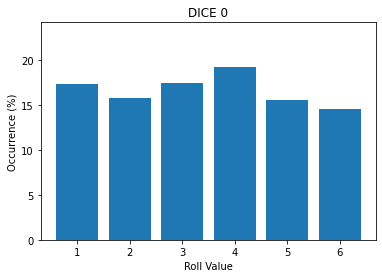

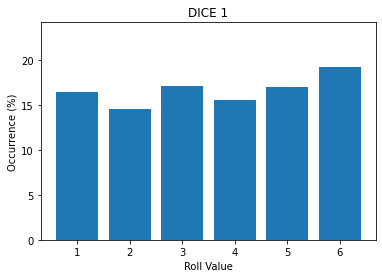

In [267]:
for axis in range(NDICES):
    np.apply_over_axes(np.sum, roll_table_normed, [i for i in range(NDICES) if i!=axis])
    occurrences = np.sum(roll_table_normed, axis=axis)*100
    plt.bar(range(1,SIDES+1), occurrences)
    plt.ylim(0,max(occurrences)+5)
    plt.xticks(range(1,SIDES+1))
    plt.title(f"DICE {axis}")
    plt.ylabel('Occurrence (%)')
    plt.xlabel('Roll Value')
    plt.show()

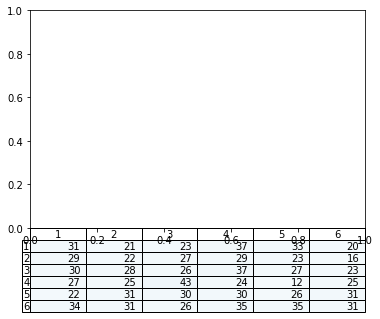

In [262]:
array2str = np.vectorize(str)
# Add a table at the bottom of the axes
the_table = plt.table(cellText=array2str(roll_table),
                      rowLabels=array2str(range(1,SIDES+1)),
                      cellColours=plt.cm.BuPu(roll_table_normed),
                      colLabels=array2str(range(1,SIDES+1)),
                      loc='bottom')

In [272]:
df = pd.DataFrame(roll_table_normed, columns=range(1,7), index=pd.Index(range(1,7)))

# === This snippet to generate a colored table displaying the results was addapted from
# https://stackoverflow.com/questions/44971502/what-code-for-a-table-with-colors-instead-of-values

from matplotlib import colors
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return [f'background-color: {color}' for color in c]

df.style.apply(background_gradient,
               cmap='RdYlGn',
               m=df.min().min(),
               M=df.max().max(),
               low=df.min().min(),
               high=df.max().max())


,1,2,3,4,5,6
1,0.031000,0.021000,0.023000,0.037000,0.033000,0.020000
2,0.029000,0.022000,0.027000,0.029000,0.023000,0.016000
3,0.030000,0.028000,0.026000,0.037000,0.027000,0.023000
4,0.027000,0.025000,0.043000,0.024000,0.012000,0.025000
5,0.022000,0.031000,0.030000,0.030000,0.026000,0.031000
6,0.034000,0.031000,0.026000,0.035000,0.035000,0.031000


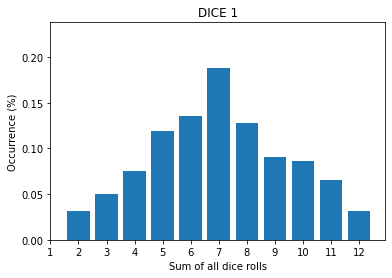

In [264]:
count, idx = np.histogram(roll_df['sum'], bins=range(2,SIDES*2+2))
idx = idx[:-1] # histogram will always return 1 more index representing bins with greater value, we don't need it
count = count.astype(np.int64) / sum(count)

plt.bar(idx, count)
plt.ylim(0,max(count)+0.05)
plt.xticks(range(1,SIDES*2+1))
plt.title(f"DICE {axis}")
plt.ylabel('Occurrence (%)')
plt.xlabel('Sum of all dice rolls')
plt.show()